In [ ]:
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Specify the folder path in your Drive
load_path = '/content/drive/My Drive/'

# Load files from Drive
solution_epsilon_r = np.load(load_path + 'solution_epsilon_r.npy')
solution_sigma = np.load(load_path + 'solution_sigma.npy')
breast_epsilon_r = np.load(load_path + 'breast_epsilon_r.npy')
breast_sigma = np.load(load_path + 'breast_sigma.npy')

sol_epsilon_r = np.load(load_path + 'solution_epsilon_r.npy')
sol_sigma = np.load(load_path + 'solution_sigma.npy')
br_epsilon_r = np.load(load_path + 'breast_epsilon_r.npy')
br_sigma = np.load(load_path + 'breast_sigma.npy')

import numpy as np

if np.array_equal(breast_sigma[0], br_sigma[0]): # Use np.array_equal for element-wise comparison
  print("images are same")
else:
  print("images are different")



images are same


# Resizing solution from 40x100x100 to 40x128x128
#Resizing Breast from 40x150x150 to 40x128x128


In [ ]:

# Cropping breast_sigma and breast_epsilon_r
def crop_center(array, target_shape):
    z, x, y = array.shape
    cropx, cropy = target_shape[1], target_shape[2]
    startx = (x - cropx) // 2
    starty = (y - cropy) // 2
    return array[:, startx:startx + cropx, starty:starty + cropy]

breast_sigma = crop_center(breast_sigma, (40, 128, 128))
breast_epsilon_r = crop_center(breast_epsilon_r, (40, 128, 128))

# Padding solution_sigma and solution_epsilon_r
def pad_to_target(array, target_shape, pad_value):
    z, x, y = array.shape
    pad_x = (target_shape[1] - x) // 2
    pad_y = (target_shape[2] - y) // 2
    padding = ((0, 0), (pad_x, target_shape[1] - x - pad_x), (pad_y, target_shape[2] - y - pad_y))
    return np.pad(array, padding, mode='constant', constant_values=pad_value)

solution_sigma = pad_to_target(solution_sigma, (40, 128, 128), pad_value=0)
solution_epsilon_r = pad_to_target(solution_epsilon_r, (40, 128, 128), pad_value=10)

# Verifying shapes
print("Shape of cropped breast_sigma:", breast_sigma.shape)
print("Shape of cropped breast_epsilon_r:", breast_epsilon_r.shape)
print("Shape of padded solution_sigma:", solution_sigma.shape)
print("Shape of padded solution_epsilon_r:", solution_epsilon_r.shape)


Shape of cropped breast_sigma: (40, 128, 128)
Shape of cropped breast_epsilon_r: (40, 128, 128)
Shape of padded solution_sigma: (40, 128, 128)
Shape of padded solution_epsilon_r: (40, 128, 128)


In [ ]:
# Cropping br_sigma and br_epsilon_r
def crop_center(array, target_shape):
    z, x, y = array.shape
    cropx, cropy = target_shape[1], target_shape[2]
    startx = (x - cropx) // 2
    starty = (y - cropy) // 2
    return array[:, startx:startx + cropx, starty:starty + cropy]

br_sigma = crop_center(br_sigma, (40, 128, 128))
br_epsilon_r = crop_center(br_epsilon_r, (40, 128, 128))

# Padding sol_sigma and sol_epsilon_r
def pad_to_target(array, target_shape, pad_value):
    z, x, y = array.shape
    pad_x = (target_shape[1] - x) // 2
    pad_y = (target_shape[2] - y) // 2
    padding = ((0, 0), (pad_x, target_shape[1] - x - pad_x), (pad_y, target_shape[2] - y - pad_y))
    return np.pad(array, padding, mode='constant', constant_values=pad_value)

sol_sigma = pad_to_target(sol_sigma, (40, 128, 128), pad_value=0)
sol_epsilon_r = pad_to_target(sol_epsilon_r, (40, 128, 128), pad_value=10)

# Verifying shapes
print("Shape of cropped br_sigma:", br_sigma.shape)
print("Shape of cropped br_epsilon_r:", br_epsilon_r.shape)
print("Shape of padded sol_sigma:", sol_sigma.shape)
print("Shape of padded sol_epsilon_r:", sol_epsilon_r.shape)


Shape of cropped br_sigma: (40, 128, 128)
Shape of cropped br_epsilon_r: (40, 128, 128)
Shape of padded sol_sigma: (40, 128, 128)
Shape of padded sol_epsilon_r: (40, 128, 128)


In [ ]:
print("min and max value of breast sigma are", breast_sigma.min(), breast_sigma.max(),"solution sigma are", solution_sigma.min(), solution_sigma.max())
print("min and max value of breast are", breast_epsilon_r.min(), breast_epsilon_r.max(),"solution sigma are", solution_epsilon_r.min(), solution_epsilon_r.max())

min and max value of breast sigma are 0.0 1.3479349233912112 solution sigma are 0.0 1.04329
min and max value of breast are 2.495753363710053 61.57131747532682 solution sigma are 2.5058510638297875 58.0


#Tumor addition
tumors are added keeping following things in mind:


*   Background values of breast_epsilon_r is 10 and of breast_sigma is 10. (Tumors are not added in these region)
*   Tumors have high sigma and epsilon values
*   Binary masks corresponding to each tumor added image is also created for segmentation task in future
*   Tumors are between the range of 0.6 to 1.6 cm.
*   cm to pixel ratio is kept at 128/10









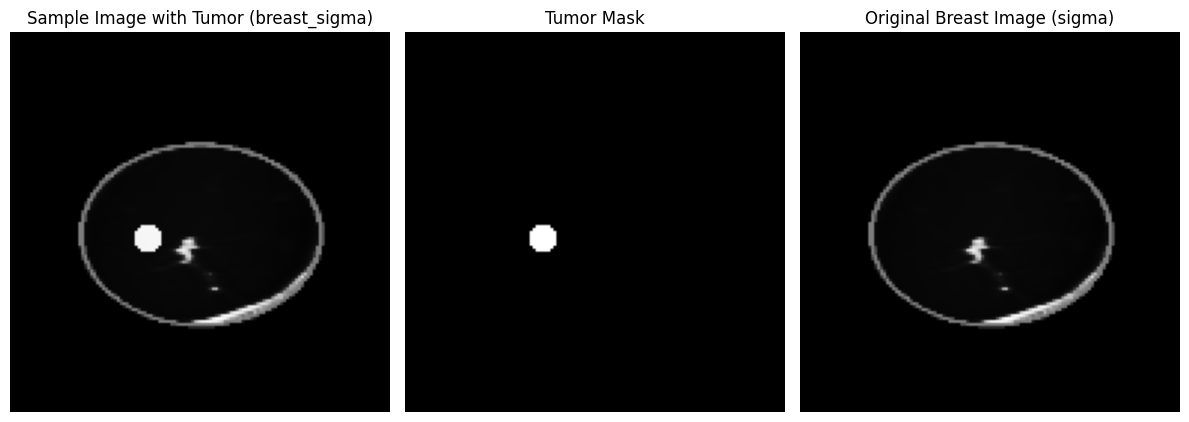

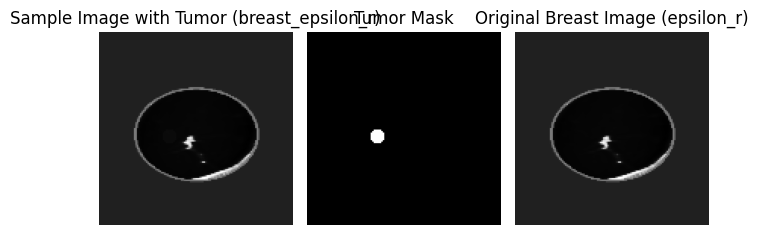

In [ ]:
import random
import math
import numpy as np
import matplotlib.pyplot as plt

# Function to add a tumor to the image without placing it in the background
def add_tumor(image, background_value, min_diameter, max_diameter, min_value, max_value):
    cm_to_pixels = 128 / 10.0  # Conversion from cm to pixels
    min_radius = (min_diameter / 2) * cm_to_pixels
    max_radius = (max_diameter / 2) * cm_to_pixels

    valid_regions = np.where(image != background_value)
    if valid_regions[0].size == 0:
        return image, np.zeros_like(image, dtype=bool)

    tumor_added = False
    retries = 0
    max_retries = 100
    tumor_mask = np.zeros_like(image, dtype=bool)

    while not tumor_added and retries < max_retries:
        center_y, center_x = random.choice(list(zip(valid_regions[0], valid_regions[1])))
        radius = random.uniform(min_radius, max_radius)

        y, x = np.ogrid[:image.shape[0], :image.shape[1]]
        mask = (x - center_x)**2 + (y - center_y)**2 <= radius**2 #circular mask banara

        if np.all(image[mask] != background_value):
            tumor_value = random.uniform(min_value, max_value)
            image[mask] = tumor_value
            tumor_mask[mask] = True
            tumor_added = True

        retries += 1

    return image, tumor_mask

# Function to add tumors to each 128x128 image in the dataset and generate tumor masks
def add_tumors_to_images(images_sigma, images_epsilon_r, min_diameter, max_diameter,
                          sigma_min, sigma_max, epsilon_min, epsilon_max, background_sigma, background_epsilon):
    tumor_masks = []

    for i in range(images_sigma.shape[0]):
        # Add the same tumor to both sigma and epsilon_r images
        images_sigma[i], tumor_mask = add_tumor(images_sigma[i], background_sigma,
                                                min_diameter, max_diameter, sigma_min, sigma_max)
        images_epsilon_r[i][tumor_mask] = random.uniform(epsilon_min, epsilon_max)  # Apply tumor to epsilon_r using the same mask
        tumor_masks.append(tumor_mask)

    return images_sigma, images_epsilon_r, np.array(tumor_masks)

# Parameters
min_diameter_cm = 0.6
max_diameter_cm = 1.6
background_sigma = 0
background_epsilon = 10

tumor_sigma_min = 2.5  # Example range
tumor_sigma_max = 60
tumor_epsilon_r_min = 0.5
tumor_epsilon_r_max = 1.3

# Example breast image arrays (replace these with actual breast images in your project)
images_sigma = np.copy(br_sigma)  # Using `br_sigma` as the original reference
images_epsilon_r = np.copy(br_epsilon_r)

# Add tumors to the images and generate binary masks
images_sigma, images_epsilon_r, tumor_masks = add_tumors_to_images(images_sigma, images_epsilon_r,
                                                                   min_diameter_cm, max_diameter_cm,
                                                                   tumor_sigma_min, tumor_sigma_max,
                                                                   tumor_epsilon_r_min, tumor_epsilon_r_max,
                                                                   background_sigma, background_epsilon)

tumor_images_sigma = tumor_masks + breast_sigma
tumor_images_epsilon_r = tumor_masks + breast_epsilon_r


# Plot sample image with tumor and its binary mask
plt.figure(figsize=(12, 6))

# Plot the image with tumor (breast_sigma)
plt.subplot(1, 3, 1)
plt.imshow(tumor_images_sigma[0], cmap='gray')
plt.title("Sample Image with Tumor (breast_sigma)")
plt.axis('off')

# Plot the tumor mask
plt.subplot(1, 3, 2)
plt.imshow(tumor_masks[0], cmap='gray')
plt.title("Tumor Mask")
plt.axis('off')

# Plot the original breast image (for comparison)
plt.subplot(1, 3, 3)
plt.imshow(br_sigma[0], cmap='gray')
plt.title("Original Breast Image (sigma)")
plt.axis('off')

plt.tight_layout()
plt.show()

plt.subplot(1, 3, 1)
plt.imshow(tumor_images_epsilon_r[0], cmap='gray')
plt.title("Sample Image with Tumor (breast_epsilon_r)")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(tumor_masks[0], cmap='gray')
plt.title("Tumor Mask")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(br_epsilon_r[0], cmap='gray')
plt.title("Original Breast Image (epsilon_r)")
plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
# prompt: save tumor_masks and tumor_images_sigma and tumor_images_epsilon_r as npy files

# Save tumor_masks, tumor_images_sigma, and tumor_images_epsilon_r as .npy files
np.save('tumor_masks.npy', tumor_masks)
np.save('tumor_images_sigma.npy', tumor_images_sigma)
np.save('tumor_images_epsilon_r.npy', tumor_images_epsilon_r)



In [ ]:
# prompt: save solution_epsilon_r and solution_sigma as npy files

np.save('solution_epsilon_r.npy', solution_epsilon_r)
np.save('solution_sigma.npy', solution_sigma)
solution_epsilon_r.shape

(40, 128, 128)